In [1]:
import csv
import google.datalab.storage as storage
import io
import math as m
import matplotlib.pyplot as plt
import numpy as np
#import numpy.ma as ma
import pandas as pd
#from statsmodels.distributions.empirical_distribution import ECDF

## Preliminaries

### Function definitions

In [2]:
def read_file(bucket, filepath, **kwargs):
  uri = bucket.object(filepath).uri
  get_ipython().run_line_magic('gcs', 'read --object ' + uri + ' --variable csv_data')
  return pd.read_csv(io.BytesIO(csv_data), **kwargs)

In [3]:
def write_df_to_csv(df, index_label, csv_filepath):
  df.to_csv('temp.csv', index_label = index_label)
  !gsutil cp 'temp.csv' $csv_filepath

In [4]:
def save_as(temp_filename, filepath):
  !gsutil cp $temp_filename $filepath

In [5]:
def heatmap(data, title, xlab, ylab, xticks, yticks, xticklabels, yticklabels, xsz, ysz, cmap, **kwargs):
    fig, ax = plt.subplots()
    if 'label_fontsize' in kwargs:
        ax.set_title(title, fontsize=kwargs['title_fontsize'])
        ax.set_xlabel(xlab, fontsize=kwargs['label_fontsize'])
        ax.set_ylabel(ylab, fontsize=kwargs['label_fontsize'])
    else:
        ax.set_title(title)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    xticklab_dict = dict()
    if ('xticklabels_rotation' in kwargs):
        xticklab_dict['rotation'] = kwargs['xticklabels_rotation']
    if ('ha' in kwargs):
        xticklab_dict['ha'] = kwargs['ha']
    ax.set_xticklabels(xticklabels, xticklab_dict)
    if 'va' in kwargs:
        ax.set_yticklabels(yticklabels, va=kwargs['va'])
    else:
        ax.set_yticklabels(yticklabels)
    fig.set_size_inches(xsz, ysz)
    cmap.set_under()
    heatmap = ax.pcolormesh(data, cmap=cmap)
    fig.colorbar(heatmap, ax=ax)
    return fig

### Initialise bucket

In [6]:
bucket = storage.Bucket('yfl-mirna')

### Load data

#### miRNA data

In [7]:
miRNA_data = read_file(bucket, 'data/miRNA/pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.csv')

In [8]:
miRNA_data.rename(index=str, columns={'Genes': 'miRNA'}, inplace=True)
miRNA_data.set_index('miRNA', inplace=True)
miRNA_data['Corrected'] = (miRNA_data['Correction'] == 'Corrected')
del miRNA_data['Correction']

In [9]:
miRNA_corrections = pd.DataFrame(miRNA_data[['Corrected']])
del miRNA_data['Corrected']

In [11]:
sample_miRNAs = miRNA_data.T
sample_miRNAs.index = sample_miRNAs.index.map(lambda x: '-'.join(x.split('-')[0:4]))
sample_miRNAs.reset_index(inplace=True)
sample_miRNAs.drop_duplicates(subset='index', keep='first', inplace=True)
sample_miRNAs.set_index('index', inplace=True)

#### Sample metadata

In [12]:
sample_metadata = read_file(bucket, 'data/sample/PanCanAtlas_miRNA_sample_information_list.txt', delimiter='\t')

In [13]:
sample_metadata.rename(index=str, columns={'id': 'sample'}, inplace=True)
sample_metadata.set_index('sample', inplace=True)
sample_metadata.index = sample_metadata.index.map(lambda x: '-'.join(x.split('-')[0:4]))
sample_metadata.reset_index(inplace=True)
sample_metadata.drop_duplicates(subset='sample', keep='first', inplace=True)
sample_metadata.set_index('sample', inplace=True)

#### Pan-cancer miRNA-mRNA expression Spearman correlations

In [14]:
mirtar_spearman_corrs = read_file(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corrs.csv')
mirtar_spearman_corrs.set_index('miRNA', inplace=True)

### More processing

#### Merge sample miRNA expression and sample metadata

In [15]:
sample_data_miRNAs = pd.merge(sample_metadata, sample_miRNAs, left_index=True, right_index=True)

#### Considering samples of type 1 only

In [16]:
type_1_sample_data_miRNAs = pd.DataFrame(sample_data_miRNAs[sample_data_miRNAs.Sample_Type == 1])
type_1_sample_miRNAs = type_1_sample_data_miRNAs.drop(columns=sample_metadata.columns)

#### Tumour types and counts

In [17]:
cancer_types_and_counts = type_1_sample_data_miRNAs['Disease'].value_counts().sort_values()
cancer_types_and_counts_with_pancan = cancer_types_and_counts.append(pd.Series([type_1_sample_data_miRNAs.shape[0]], ['PAN']))
cancer_types = cancer_types_and_counts.index
cancer_types_list = cancer_types_and_counts_with_pancan.index

#### miRNA sample expression by tumor type

In [18]:
sample_disease_miRNAs = type_1_sample_data_miRNAs.drop(columns=['Sample_Type', 'Protocol', 'Platform'])
samples_by_cancer_type = sample_disease_miRNAs.groupby('Disease')
cancer_type_miRNA_means = samples_by_cancer_type.mean()

## Analysis

In [19]:
quantiles_count = 20.0
quantile_ranks = np.arange(1, 21, 1) / quantiles_count

In [20]:
def init_dataframe(index, cols, index_name):
  df = pd.DataFrame(index = index, columns = cols)
  df.index.name = index_name
  return df

### Compute expression quantile miRNAs

#### Define quantile ranks and the corresponding indices for miRNAs

In [22]:
miRNA_quantile_indices = np.array([int(m.ceil(x) - 1) for x in (miRNA_data.shape[0] * quantile_ranks)])

#### miRNA mean expression quantile miRNAs per cancer type

In [23]:
cancer_type_mean_expr_quantile_miRNAs = pd.DataFrame(index = cancer_types_list, columns = quantile_ranks)
for cancer_type in cancer_types:
    miRNA_list = cancer_type_miRNA_means.loc[cancer_type].sort_values()[miRNA_quantile_indices].index
    cancer_type_mean_expr_quantile_miRNAs.loc[cancer_type] = miRNA_list
cancer_type_mean_expr_quantile_miRNAs.loc['PAN'] = type_1_sample_miRNAs.mean().sort_values()[miRNA_quantile_indices].index

In [64]:
write_df_to_csv(cancer_type_mean_expr_quantile_miRNAs, 'Cancer Type', 'gs://yfl-mirna/analysis/ceRNA/cancer-type_mean-expr-quantile-miRNAs.csv')

Copying file://temp.csv [Content-Type=text/csv]...
/ [1 files][  9.6 KiB/  9.6 KiB]                                                
Operation completed over 1 objects/9.6 KiB.                                      


### Compute miRNA-mRNA anticorrelation quantiles

In [24]:
def anticorr_quantiles_for_cancertype_and_miRNAs(rank, type_mirtar_corrs, miRNA_expr_quantile_ranks, miRNAs):
  quantiles = type_mirtar_corrs.apply(lambda r: r.quantile(rank), axis=1)[miRNAs]
  quantiles.index = miRNA_expr_quantile_ranks
  return quantiles

#### mRNA expression anticorrelation quantiles for quantile miRNAs from last step

In [25]:
cancer_type_quantile_miRNA_anticorr_50iles = init_dataframe(cancer_types_list, quantile_ranks, 'cancer_type')
cancer_type_quantile_miRNA_anticorr_1iles = init_dataframe(cancer_types_list, quantile_ranks, 'cancer_type')

In [131]:
for cancer_type in cancer_types:
    type_mirtar_spearman_corrs = read_file(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corrs_' + cancer_type + '.csv')
    type_mirtar_spearman_corrs.set_index('miRNA', inplace=True)
    cancer_type_quantile_miRNA_anticorr_50iles.loc[cancer_type] = anticorr_quantiles_for_cancertype_and_miRNAs(0.5, type_mirtar_spearman_corrs, quantile_ranks,
                                                                                                               cancer_type_mean_expr_quantile_miRNAs.loc[cancer_type])
    cancer_type_quantile_miRNA_anticorr_1iles.loc[cancer_type] = anticorr_quantiles_for_cancertype_and_miRNAs(0.01, type_mirtar_spearman_corrs, quantile_ranks,
                                                                                                              cancer_type_mean_expr_quantile_miRNAs.loc[cancer_type])
cancer_type_quantile_miRNA_anticorr_50iles.loc['PAN'] = anticorr_quantiles_for_cancertype_and_miRNAs(0.5, mirtar_spearman_corrs, quantile_ranks,
                                                                                                     cancer_type_mean_expr_quantile_miRNAs.loc['PAN'])
cancer_type_quantile_miRNA_anticorr_1iles.loc['PAN'] = anticorr_quantiles_for_cancertype_and_miRNAs(0.01, mirtar_spearman_corrs, quantile_ranks,
                                                                                                    cancer_type_mean_expr_quantile_miRNAs.loc['PAN'])
cancer_type_quantile_miRNA_anticorr_50iles = cancer_type_quantile_miRNA_anticorr_50iles.astype('float64')
cancer_type_quantile_miRNA_anticorr_1iles = cancer_type_quantile_miRNA_anticorr_1iles.astype('float64')

In [ ]:
write_df_to_csv(cancer_type_quantile_miRNA_anticorr_50iles, 'cancer_type', 'gs://yfl-mirna/analysis/ceRNA/cancer-type_quantile-miRNA_anticorr-50iles.csv')
write_df_to_csv(cancer_type_quantile_miRNA_anticorr_1iles, 'cancer_type', 'gs://yfl-mirna/analysis/ceRNA/cancer-type_quantile-miRNA_anticorr-1iles.csv')

### Cancer type vs. miRNA expression: miRNA-mRNA expression anticorrelation heatmaps

#### TODO: Delete next cell when done

In [26]:
cancer_type_quantile_miRNA_anticorr_50iles = read_file(bucket, 'analysis/ceRNA/cancer-type_quantile-miRNA_anticorr-50iles.csv')
cancer_type_quantile_miRNA_anticorr_50iles.set_index('cancer_type', inplace=True)
cancer_type_quantile_miRNA_anticorr_1iles = read_file(bucket, 'analysis/ceRNA/cancer-type_quantile-miRNA_anticorr-1iles.csv')
cancer_type_quantile_miRNA_anticorr_1iles.set_index('cancer_type', inplace=True)

In [ ]:
heatmap(cancer_type_quantile_miRNA_anticorr_50iles, 'miRNA-mRNA expression anticorrelation medians', 'miRNA expression mean quantiles',
        'Cancer type, sorted by increasing sample size', quantile_ranks * 20, range(cancer_types_list.shape[0]), quantile_ranks, cancer_types_list,
        10, cancer_types_list.shape[0] * 0.5, plt.cm.cubehelix, title_fontsize = 24, label_fontsize = 18, va = 'bottom').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/ceRNA/plots/cancer-type_miRNA-quantiles_mRNA-anticorr-medians.png')

In [ ]:
heatmap(cancer_type_quantile_miRNA_anticorr_1iles, 'miRNA-mRNA expression anticorrelation 99th percentiles', 'miRNA expression mean quantiles',
        'Cancer type, sorted by increasing sample size', quantile_ranks * 20, range(cancer_types_list.shape[0]), quantile_ranks, cancer_types_list,
        10, cancer_types_list.shape[0] * 0.5, plt.cm.cubehelix, title_fontsize = 24, label_fontsize = 18, va = 'bottom').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/ceRNA/plots/cancer-type_miRNA-quantiles_mRNA-anticorr-99iles.png')

### Compute joint distribution of miRNA mean expression and number of targets, sort of

In [ ]:
quantile_groups = range(int(quantiles_count))

In [220]:
def get_quantiles_for_mean_expr_gp(mean_expr_gp, quantile_colname):
  mean_expr_col = pd.Series(index = range(int(quantiles_count)))
  for r in mean_expr_col.index:
    mean_expr_target_count_gp = mean_expr_gp[mean_expr_gp.target_count_quantile_gp == r]
    if mean_expr_target_count_gp.size > 0:
      mean_expr_col[r] = mean_expr_target_count_gp.iloc[-1][quantile_colname]
  return mean_expr_col

#### Combine miRNA mean expression, target counts, and mRNA expression anticorrelation quantiles into a single dataframe

In [265]:
miRNA_target_counts = read_file(bucket, 'data/miRTar/miRNA-target-counts.csv', header=None)
miRNA_target_counts.rename(columns = { 0: 'miRNA', 1: 'target_count' }, inplace=True)
miRNA_target_counts.sort_values(by='target_count', inplace=True)
miRNA_target_counts.set_index('miRNA', inplace=True)
obs_per_quantile_gp = miRNA_target_counts.index.size / quantiles_count
miRNA_target_counts['target_count_quantile_gp'] = (miRNA_target_counts.reset_index().index / obs_per_quantile_gp).astype(int)

In [267]:
miRNA_mean_exprs = type_1_sample_miRNAs.mean().sort_values().to_frame().rename({ 0: 'mean_expr' }, axis=1)
obs_per_quantile_gp = miRNA_mean_exprs.index.size / quantiles_count
miRNA_mean_exprs['mean_expr_quantile_gp'] = (miRNA_mean_exprs.reset_index().index / obs_per_quantile_gp).astype(int)

In [269]:
miRNA_expr_targetcount_anticorrs = miRNA_target_counts.join(miRNA_mean_exprs)
miRNA_expr_targetcount_anticorrs.sort_values(by = ['mean_expr', 'target_count'], inplace = True)
miRNA_expr_targetcount_anticorrs['anticorr_50ile'] = mirtar_spearman_corrs.quantile(0.5, axis=1)[miRNA_expr_targetcount_anticorrs.index]
miRNA_expr_targetcount_anticorrs['anticorr_99ile'] = mirtar_spearman_corrs.quantile(0.01, axis=1)[miRNA_expr_targetcount_anticorrs.index]

#### Joint distribution of miRNA mean expression and number of targets

In [272]:
miRNA_meanexpr_vs_targetcount_obs = pd.DataFrame(index = quantile_groups, columns = quantile_groups)
miRNAmiRNA_expr_targetcount_gps = miRNA_expr_targetcount_anticorrs.groupby(['mean_expr_quantile_gp', 'target_count_quantile_gp']).size()
for mean_expr_quantile_gp in miRNA_meanexpr_vs_targetcount_obs.columns:
  miRNA_meanexpr_vs_targetcount_obs[mean_expr_quantile_gp][miRNAmiRNA_expr_targetcount_gps[mean_expr_quantile_gp].index] = miRNAmiRNA_expr_targetcount_gps[mean_expr_quantile_gp]

In [ ]:
heatmap(miRNA_meanexpr_vs_targetcount_obs.astype('float64'), 'miRNA mean expression vs. target count quantile groups: numbers of observations', 'miRNA expression mean quantile groups',
        'miRNA number of targets quantile groups', quantile_groups, quantile_groups, quantile_groups, quantile_groups,
        int(quantiles_count) / 2, int(quantiles_count) / 2, plt.cm.cubehelix_r, title_fontsize = 18, label_fontsize = 12, ca = 'center', va = 'center')
#.savefig('temp.png')

#### Compute (for) heatmaps

In [230]:
miRNA_targetcount_vs_expr_mRNA_anticorr_50iles = pd.DataFrame(index = quantile_groups, columns = quantile_groups)
miRNA_targetcount_vs_expr_mRNA_anticorr_99iles = pd.DataFrame(index = quantile_groups, columns = quantile_groups)

In [231]:
for c in miRNA_targetcount_vs_expr_mRNA_anticorr_50iles.columns:
  mean_expr_gp = miRNA_expr_targetcount_anticorrs[miRNA_expr_targetcount_anticorrs.mean_expr_quantile_gp == c]
  miRNA_targetcount_vs_expr_mRNA_anticorr_50iles[c] = get_quantiles_for_mean_expr_gp(mean_expr_gp, 'anticorr_50ile')
  miRNA_targetcount_vs_expr_mRNA_anticorr_99iles[c] = get_quantiles_for_mean_expr_gp(mean_expr_gp, 'anticorr_99ile')

In [ ]:
miRNA_targetcount_vs_expr_mRNA_anticorr_99iles



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://temp.png [Content-Type=image/png]...
/ [1 files][ 35.5 KiB/ 35.5 KiB]                                                
Operation completed over 1 objects/35.5 KiB.                                     


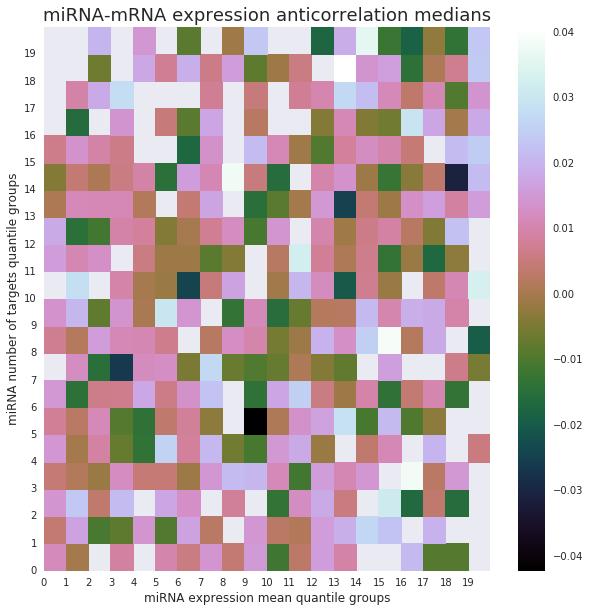

In [238]:
heatmap(miRNA_targetcount_vs_expr_mRNA_anticorr_50iles, 'miRNA-mRNA expression anticorrelation medians', 'miRNA expression mean quantile groups',
        'miRNA number of targets quantile groups', quantile_groups, quantile_groups, quantile_groups, quantile_groups,
        int(quantiles_count) / 2, int(quantiles_count) / 2, plt.cm.cubehelix, title_fontsize = 18, label_fontsize = 12, ca = 'center', va = 'center').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/ceRNA/plots/miRNA-targetcount-vs-expr-quantilegps_mRNA-anticorr-medians.png')

Copying file://temp.png [Content-Type=image/png]...
- [1 files][ 34.5 KiB/ 34.5 KiB]                                                
Operation completed over 1 objects/34.5 KiB.                                     


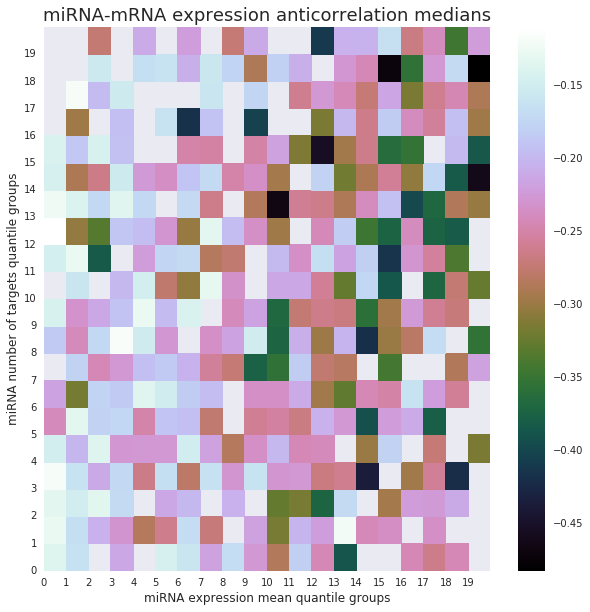

In [239]:
heatmap(miRNA_targetcount_vs_expr_mRNA_anticorr_99iles, 'miRNA-mRNA expression anticorrelation medians', 'miRNA expression mean quantile groups',
        'miRNA number of targets quantile groups', quantile_groups, quantile_groups, quantile_groups, quantile_groups,
        int(quantiles_count) / 2, int(quantiles_count) / 2, plt.cm.cubehelix, title_fontsize = 18, label_fontsize = 12, ca = 'center', va = 'center').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/ceRNA/plots/miRNA-targetcount-vs-expr-quantilegps_mRNA-anticorr-99iles.png')

## Scraps

In [56]:
samples_sortedby_tumor_type = sample_disease_miRNAs.sort_values(by=['Disease'])
sample_tumor_types_sorted = samples_sortedby_tumor_type['Disease']

miRNA_samples_by_tumor_type = samples_sortedby_tumor_type.drop(columns=['Disease']).T
miRNA_samples_by_tumor_type['mean_expr'] = miRNA_samples_by_tumor_type.mean(axis=1)

In [57]:
miRNA_samples_by_tumor_type.head()

,TCGA-OR-A5J1-01A,TCGA-OR-A5LC-01A,TCGA-OR-A5LB-01A,TCGA-OR-A5LA-01A,TCGA-OR-A5L9-01A,TCGA-OR-A5L8-01A,TCGA-OR-A5L6-01A,TCGA-OR-A5L5-01A,TCGA-OR-A5LD-01A,TCGA-OR-A5L4-01A,...,TCGA-V4-A9EX-01A,TCGA-V4-A9EW-01A,TCGA-V4-A9EV-01A,TCGA-V4-A9EU-01A,TCGA-V4-A9ET-01A,TCGA-V4-A9ES-01A,TCGA-V4-A9EQ-01A,TCGA-VD-A8K9-01A,TCGA-YZ-A985-01A,mean_expr
hsa-let-7a-2-3p,1.516652,4.055588,1.222368,1.179666,1.361217,1.697989,3.170057,4.565757,0.869746,1.531810,...,0.403806,4.836469,0.372345,0.804193,2.075611,0.161250,0.161250,0.830944,0.161250,7.924000
hsa-let-7a-3p,74.323353,44.832493,23.528583,51.936385,38.674034,30.700558,24.327827,59.129552,62.502435,27.829411,...,30.394728,19.178473,10.812286,22.369586,5.463725,19.218429,14.113464,12.883255,9.761276,34.106855
hsa-let-7a-5p,44763.181080,22656.325020,30223.225340,38427.513240,36414.642840,55062.589630,36227.912510,46736.709130,20626.693230,34549.988200,...,66483.753540,66272.391770,83424.119630,66579.633860,80227.064680,103809.075700,146520.163400,65955.612130,72332.119210,33768.287529
hsa-let-7b-3p,44.861733,30.705416,31.011989,17.620770,29.526437,27.954160,12.503146,31.912779,18.456039,33.048252,...,46.013314,61.679150,66.180343,62.928663,40.281762,37.411208,38.995330,7.457725,31.368915,35.622075
hsa-let-7b-5p,16813.804970,11870.737970,11145.286060,13675.645030,15149.611650,14681.161980,5176.657674,11619.951270,6278.523528,6076.989394,...,40269.888310,31486.584240,32287.621540,29084.078460,40897.905380,18329.608670,55389.247750,12068.699000,50420.089490,19282.396209
